In [80]:
import numpy as np
import pandas as pd
import itertools
import statsmodels.api as sm
from statsmodels.regression.mixed_linear_model import MixedLM
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import silhouette_score
from sklearn.cluster import DBSCAN, HDBSCAN, MiniBatchKMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import kneighbors_graph
from sklearn.cluster import SpectralClustering

In [81]:
# from data_load import Data
# load = Data()
# load.HOMES_FOR_SALE()
# load.INCOME()
# load.HOMICIDES()
# load.POPULATION()
# load.ZIP_COUNTY()

In [82]:
from Final_Data_Output import Final_Data as FD
FD = FD()
Master_df = FD.Merge_all(min_price=1000000, max_bed=12, max_bath=10, max_sqft=4000, min_sqft=1)
Master_df['log_price'] = np.log(Master_df['price'])
Master_df = Master_df.loc[Master_df['acre_lot'] < 10, :]
Master_df.info()

c:\Users\elang\Documents\CDA\House_Prices_Project\Final_Data_Output.py:95: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['Homicides'] = df['Homicides'].fillna(0)


<class 'pandas.core.frame.DataFrame'>
Index: 67938 entries, 3 to 70754
Data columns (total 55 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   Unnamed: 0_x           67938 non-null  int64   
 1   brokered_by            67938 non-null  float64 
 2   status                 67938 non-null  object  
 3   price                  67938 non-null  float64 
 4   bed                    67938 non-null  float64 
 5   bath                   67938 non-null  float64 
 6   acre_lot               67938 non-null  float64 
 7   street                 67938 non-null  float64 
 8   city_x                 67938 non-null  object  
 9   state_x                67938 non-null  object  
 10  zip_code               67938 non-null  float64 
 11  house_size             67938 non-null  float64 
 12  prev_sold_date         67938 non-null  object  
 13  Households             67162 non-null  float64 
 14  Total_AGI              67162 non-null  floa

In [83]:
df = Master_df[['bed', 'bath', 'house_size', 'acre_lot', 'zip_code', 'Household_AGI', 'Total_Pop', 'Homicides', 'log_price']]
df = df.dropna()
df = sm.add_constant(df)
df.shape

(67162, 10)

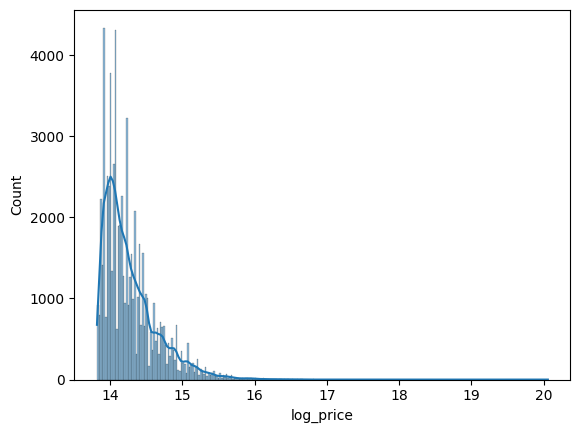

In [84]:
sns.histplot(df['log_price'], kde=True)
plt.show()

In [85]:
df.corr()

,const,bed,bath,house_size,acre_lot,zip_code,Household_AGI,Total_Pop,Homicides,log_price
const,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
bed,NaN,1.000000,0.526601,0.525397,-0.058044,-0.151957,-0.109455,0.104029,-0.046348,0.081580
bath,NaN,0.526601,1.000000,0.685566,0.014881,-0.249752,0.015370,-0.075411,-0.024921,0.238251
house_size,NaN,0.525397,0.685566,1.000000,0.116596,-0.213574,0.007716,-0.110489,-0.070222,0.219080
acre_lot,NaN,-0.058044,0.014881,0.116596,1.000000,-0.027051,-0.044061,-0.143718,-0.080135,-0.003577
zip_code,NaN,-0.151957,-0.249752,-0.213574,-0.027051,1.000000,-0.078733,0.175909,0.232024,0.007080
Household_AGI,NaN,-0.109455,0.015370,0.007716,-0.044061,-0.078733,1.000000,-0.288429,-0.006091,0.393187
Total_Pop,NaN,0.104029,-0.075411,-0.110489,-0.143718,0.175909,-0.288429,1.000000,0.058840,-0.156175
Homicides,NaN,-0.046348,-0.024921,-0.070222,-0.080135,0.232024,-0.006091,0.058840,1.000000,0.016947
log_price,NaN,0.081580,0.238251,0.219080,-0.003577,0.007080,0.393187,-0.156175,0.016947,1.000000


In [86]:
X_train, X_test, y_train, y_test = train_test_split(df[['const','bed', 'bath', 'house_size', 'acre_lot', 'zip_code', 'Household_AGI', 
                                                        'Total_Pop', 'Homicides']], df[['log_price']], test_size=0.33, random_state=42)
X_train_fe = X_train[['const','bed', 'bath', 'house_size', 'acre_lot',
                                      'Household_AGI', 'Total_Pop', 'Homicides']]
exog_re = X_train[['const','bed', 'bath', 'house_size', 'acre_lot',
                                   'Household_AGI', 'Total_Pop', 'Homicides']]
exog_re = np.ones((len(X_train), 1))

In [87]:
mod = sm.MixedLM(y_train, X_train_fe, X_train['zip_code'], exog_re=exog_re)
result = mod.fit()
print(result.summary())

          Mixed Linear Model Regression Results
Model:              MixedLM Dependent Variable: log_price 
No. Observations:   44998   Method:             REML      
No. Groups:         3937    Scale:              0.0562    
Min. group size:    1       Log-Likelihood:     -3069.5282
Max. group size:    165     Converged:          Yes       
Mean group size:    11.4                                  
----------------------------------------------------------
              Coef.  Std.Err.    z     P>|z| [0.025 0.975]
----------------------------------------------------------
const         13.290    0.013 1030.537 0.000 13.265 13.315
bed           -0.006    0.002   -3.999 0.000 -0.009 -0.003
bath           0.039    0.002   22.495 0.000  0.035  0.042
house_size     0.000    0.000   86.332 0.000  0.000  0.000
acre_lot       0.023    0.001   16.452 0.000  0.020  0.025
Household_AGI  0.001    0.000   22.672 0.000  0.001  0.001
Total_Pop     -0.000    0.000   -0.781 0.435 -0.000  0.000
Homicide

In [88]:
re = pd.DataFrame(result.random_effects).T.reset_index()
re.columns = ['zip_code', 'random_effect']
temp_df = X_test[['zip_code']].merge(re, on='zip_code', how='left')

In [89]:
exog = X_test[['const', 'bed', 'bath', 'house_size', 'acre_lot',
               'Household_AGI', 'Total_Pop', 'Homicides']]
groups = X_test['zip_code']
y_pred_mixed = result.predict(exog=exog)+ temp_df['random_effect'].values
R_squared = 1 - np.sum((y_test['log_price'] - y_pred_mixed) ** 2) / np.sum((y_test['log_price'] - np.mean(y_test['log_price'])) ** 2)
print(f'Proportion of Variance Explained: {R_squared:.4f}')

Proportion of Variance Explained: 0.5837


In [90]:
perm_df = pd.DataFrame()
zips = list(df['zip_code'].unique())
for z in zips:
    Household_AGI = df.loc[df['zip_code'] == z, 'Household_AGI'].unique()
    Total_Pop = df.loc[df['zip_code'] == z, 'Total_Pop'].unique()
    Homicides = df.loc[df['zip_code'] == z, 'Homicides'].unique()
    all_permutations = list(itertools.product(Household_AGI, Total_Pop, Homicides, [z]))
    temp_df = pd.DataFrame(all_permutations, columns=['Household_AGI', 'Total_Pop', 'Homicides', 'zip_code'])
    perm_df = pd.concat([perm_df, temp_df], ignore_index=True)
perm_df = perm_df.drop_duplicates().reset_index(drop=True)

In [91]:
def Client_criteria(min_beds=input("Minimum bedrooms you would like:"), max_beds=input("Maximum bedrooms you would like:"), min_baths=input("Minimum bathrooms you would like:"), max_baths=input("Maximum bathrooms you would like:"),
                    min_sqft=input("Minimum square footage you would like:"), max_sqft=input("Maximum square footage you would like:"), min_acre_lot=input("Minimum acreage you would like (acre=sqft/43,560):"), max_acre_lot=input("Maximum acreage you would like (acre=sqft/43,560):")):
    client_data= {'sqft': (min_sqft, max_sqft),
                  'bed': (min_beds, max_beds),
                  'bath': (min_baths, max_baths),
                  'acre_lot': (min_acre_lot, max_acre_lot)}
    return client_data
client_data = Client_criteria()
client_data = pd.DataFrame(client_data).astype(float)

In [92]:
n_smap = 1000000
predict_data = perm_df.sample(n=n_smap, replace=True, random_state=42).reset_index(drop=True)
predict_data['bed'] = np.random.randint(client_data['bed'].min(), client_data['bed'].max()+1, size=n_smap)
predict_data['bath'] = np.random.randint(client_data['bath'].min(), client_data['bath'].max()+1, size=n_smap)
predict_data['house_size'] = np.random.randint(client_data['sqft'].min(), client_data['sqft'].max()+1, size=n_smap)
predict_data['acre_lot'] = np.random.uniform(client_data['acre_lot'].min(), client_data['acre_lot'].max(), size=n_smap).round(2)
predict_data = sm.add_constant(predict_data)
exog_pred = predict_data[['const', 'bed', 'bath', 'house_size', 'acre_lot',
                          'Household_AGI', 'Total_Pop', 'Homicides']]
groups_pred = predict_data['zip_code']
re = pd.DataFrame(result.random_effects).T.reset_index()
re.columns = ['zip_code', 'random_effect']
re_df = predict_data[['zip_code']].merge(re, on='zip_code', how='left')
predict_data['Predicted_Price'] = np.exp(result.predict(exog=exog_pred) + re_df['random_effect'].values)
predict_data['Homicide_Rate'] = predict_data['Homicides'] / predict_data['Total_Pop'] * 100000
predict_data = predict_data.loc[predict_data['Predicted_Price'].notna(),].sort_values(by=['Homicide_Rate','Predicted_Price']).reset_index(drop=True)

In [98]:
predict_data.loc[predict_data['Predicted_Price'] < 800000,].head(20)

,const,Household_AGI,Total_Pop,Homicides,zip_code,bed,bath,house_size,acre_lot,Predicted_Price,Homicide_Rate
0,1.0,65.079439,23757.0,0,30528.0,4,2,2009,0.46,766316.972153,0.0
1,1.0,65.079439,23757.0,0,30528.0,4,2,2018,0.40,766819.113039,0.0
2,1.0,67.633134,7742.0,0,30817.0,4,2,2003,0.60,770437.402314,0.0
3,1.0,65.079439,23757.0,0,30528.0,4,2,2035,0.60,773209.185196,0.0
4,1.0,67.633134,7742.0,0,30817.0,4,2,2005,0.81,774437.594241,0.0
5,1.0,65.079439,23757.0,0,30528.0,4,2,2034,0.69,774606.274874,0.0
6,1.0,67.633134,7742.0,0,30817.0,4,2,2002,0.93,776015.396067,0.0
7,1.0,65.079439,23757.0,0,30528.0,3,2,2022,0.66,776686.890007,0.0
8,1.0,67.633134,7742.0,0,30817.0,4,2,2017,0.90,778089.574592,0.0
9,1.0,65.079439,23757.0,0,30528.0,4,2,2066,0.60,778573.510913,0.0
